### Authors: [Michael Lees](http://www.mhlees.com), Debraj Roy

---
The MIT License (MIT)

Copyright (c) 2015-2017 Michael Lees, Debraj Roy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---


# Epidemic spreading using NetworkX

Networks, and in particular network simulation, are a key tool in trying to predict the spread of worldwide pandemics. Many governments using modelling and simulation software to help them make decisions during an epidemic outbreak. [Gleamviz](http://www.gleamviz.org) is a nice example of a sophisticated software system that enables policy makers to predict the spread of an epidemic and decide on appropriate intervention strategies. Gleamviz has been used to predict the spread of [H1N1 in 2009](http://www.gleamviz.org/case-study/reports/) and [Ebola in 2014](http://currents.plos.org/outbreaks/article/assessing-the-international-spreading-risk-associated-with-the-2014-west-african-ebola-outbreak/).

In this class we will build a simple model of disease spread on different artificial networks and investigate different vacination policies to try and prevent or slow down the spread of the pandemic.

## Suceptible, Infected, Removed.

Disease spread can be modelled in various ways using networks, but we will consider a network where nodes represent people and edges between two nodes indicate that those two people have sufficient contact (interaction) such that a disease has a non-zero probability of transmission.

Each node (person) in the network can be in one of 3 possible states: 

1. Succeptible (the default state) - indicating the person may contract the disease if one of their neighbours has the disease.

2. Infected - the person currently has the disease and can infect their neighbours

3. Removed - the person has either recovered from the disease and is no longer infectious (and cannot contract the disease again) or the person has died.

SIR is applicable in many real world diseases, e.g., HiV, Chicken Pox, etc. The following system of differential equations can be used to describe the SIR model:

$$
\frac{ds}{dt} = -\beta i(t) s(t)
\hspace{1in}
\frac{di}{dt} = \beta i(t) s(t) - \alpha i(t)
\hspace{1in}
\frac{dr}{dt} = \alpha i(t)
$$

The constants $\alpha$ and $\beta$ describe the rate of removal (fraction of people moving from infected to removed per time unit) and the rate of infection (fraction of people moving from succeptible to infected per time unit).
In the above model the assumption is of a well mixed population, i.e., every person has a chance of infecting every other person. In many real world scenarios this assumption is too strong, the reality is that people only interact within their social circle. They will only contract and transmit the disease from and to people with whom they make contact. It is therefore interesting to try and understand how the network strucutre impacts the spread, or how it might enable effective vacination strategies.

In our network-based model each infected node has a probability of transmitting the disease to **each** of their immediate neighbours with probability $\beta$ each time step. Infected nodes also have a probability of recovering from the disease at each time step, with probabiltiy $\alpha$. So for an infected node $n_i$ with degree $k_i$, if $\alpha = \beta = 1$, $n_i$ will infect all $k_i$ neighbours, and then move to the removed state, all within a single time step.


## The code
    

We start off by importing the libraries we will use for this model.

In [1]:
import networkx as nx #import NetworkX
import numpy as np #import numpy for ...
#force drawing of graphs inline for ipython notebook
%matplotlib inline 
import matplotlib.pyplot as plt #import matplotlib for plotting/drawing grpahs
import matplotlib.patches as mpatches #for legends in the graph
from __future__ import unicode_literals #allow UTF characters in graph labels
import random # for random choice function
from tqdm import tqdm #nice library for progress bars
import sys #for printing to screen in a special way
import operator #standard python library used for sorting
from enum import * # used for the states S,I,R
import copy

## Python functions

As this model is a little more complex than the previous examples, we first define a series of python functions that will we use repeatedly later in the code. The names of the functions should be self explanatory, the comments will make things even clearer. Don't worry if you don't understand how each function works, you can treat them as a black box - but you should know what you feed into the black box and what you expect back.

In [2]:
class State(Enum): # define the three states of the nodes.
    Succeptible = 0
    Infected = 1
    Removed = 2
    
def reset(G):
    """ 
    :param G: The graph to reset
    
    Initialise/reset all the nodes in the network to be succeptible. 
    Used to initialise the network at the start of an experiment
    """
    nx.set_node_attributes(G, name='state', values=State.Succeptible)

        
def initialise_infection(G, num_to_infect):
    """
    :param G: Graph to infect nodes on
    :param num_to_infect: Number of nodes to infect on G
    
    Set the state of a random selection of nodes to be infected. 
    numToInfect specifices how many infections to make, the nodes 
    are chosen randomly from all nodes in the network
    """
    nodes_to_infect = random.sample(G.nodes(), num_to_infect)
    for n in nodes_to_infect:
        G.nodes[n]['state'] = State.Infected
    return nodes_to_infect
        
def transmission_model_factory(beta=0.03, alpha=0.05):
    """
    :param beta: specifies the rate of infection (movement from S to I)
    :param alpha: specifies the rate of removal (movement from I to R)
    :returns: a function specifying infection model.
    
    Creates and returns an instance of a infection model. This allows us 
    to create a number of models with different beta and alpha parameters.
    Note that in a single time step an infected node can infect their neighbours
    and then be removed.
    """
    def m(n, G):
        list_of_neighbours_to_infect = [] #list of neighbours will be infect after executing this step
        removeMyself = False #should I change my state to removed?
        if G.nodes[n]['state'] == State.Infected:
            # infect susceptible neighbours with probability beta
            for k in G.neighbors(n):
                if G.nodes[k]['state'] == State.Succeptible:
                    if random.random() <= beta: #generate random number between 0 and 1
                        list_of_neighbours_to_infect.append(k)
            if random.random() <= alpha:
                removeMyself = True
        return list_of_neighbours_to_infect, removeMyself
    return m

def apply_infection(G, list_of_newly_infected, list_of_newly_removed):
    """
    :param G: The graph on which to operate
    :param list_of_newly_infected: A list of nodes to infect (move from S to I)
    :param list_of_newly_removed: A list of nodes to remove (movement from I to R)
    
    Applies the state changes to nodes in the network. Note that the transmission model
    actually builds a list of nodes to infect and to remove.
    """
    for n in list_of_newly_infected:
        G.nodes[n]['state'] = State.Infected
    for n in list_of_newly_removed:
        G.nodes[n]['state'] = State.Removed

def execute_one_step(G, model):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G

    executes the infection model on all nodes in G
    """
    new_nodes_to_infect=[] #nodes to infect after executing all nodes this time step   
    new_nodes_to_remove=[] #nodes to set to removed after this time step   
    for n in G: #for each node in graph,
        i,remove = model(n, G) #execute transmission model on node n
        new_nodes_to_infect = new_nodes_to_infect + i #add neigbours of n that are infected
        if remove: #if I should remove this node? determined by model 
            new_nodes_to_remove.append(n) 
    apply_infection(G, new_nodes_to_infect, new_nodes_to_remove)

def get_infection_stats(G):
    """
    :param G: the Graph on which to execute the infection model
    :returns: a tuple containing three lists of succeptible, infected and removed nodes.

    Creates lists of nodes in the graph G that are succeptible, infected and removed.
    """
    infected = [] #list of infected nodes
    succeptible = [] #list of succeptible
    removed = [] #list of removed nodes
    for n in G:
        if G.nodes[n]['state'] == State.Infected:
            infected.append(n)
        elif G.nodes[n]['state'] == State.Succeptible:
            succeptible.append(n)
        else:
            removed.append(n)
    return succeptible, infected, removed #return the three lists.


def print_infection_stats(G):
    """
    :param G: the Graph on which to execute the infection model

    Prints the number of succeptible, infected and removed nodes in graph G.
    """
    s,i,r = get_infection_stats(G)
#     print "Succeptible: %d Infected: %d Removed %d"% (len(s),len(i),len(r))

def run_spread_simulation(G, model, initial_infection_count, run_visualise=False):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G
    :param initial_infection_count: Number of nodes to infect on G
    :param run_visualise: if set to true a visual representation of the network 
                          will be written to file at each time step
    :returns : a 5-tuple containing, list of S,I,R nodes at end, the end time 
               and the list of initially infected nodes (useful for visulisation)

    Runs a single simulation of infection on the graph G, using the specified model. 
    An initial infection count is specified to infect a set of nodes. 
    The simulation is executed until there are no more infected nodes, that is the 
    infection dies out, or everyone ends up removed.
    """
    initially_infected = initialise_infection(G, initial_infection_count)

    s_results = []
    i_results = []
    r_results = []

    dt = 0
    s,i,r = get_infection_stats(G)
    
    pos = nx.spring_layout(G, k=.75)
    
    while len(i) > 0:
        execute_one_step(G, model) #execute each node in the graph once
        dt += 1 #increase time step
        s,i,r = get_infection_stats(G) #calculate SIR stats of the current time step
        s_results.append(len(s)) #add S counts to our final results
        i_results.append(len(i)) #add I counts to our final results
        r_results.append(len(r)) #add R counts to our final results
        sys.stderr.write('\rInfected: %d time step: %d' % (len(i), dt))
        sys.stderr.flush()
        if run_visualise: #If run visualise is true, we output the graph to file
            draw_network_to_file(G,pos,dt,initially_infected)
    return s_results, i_results, r_results, dt, initially_infected #return our results for plotting

def plot_infection(S,I,R,G):
    """
    :param S: time-ordered list from simulation output indicating how succeptible count changes over time
    :param I: time-ordered list from simulation output indicating how infected count changes over time
    :param R: time-ordered list from simulation output indicating how removed count changes over time
    :param G: Graph/Network of statistic to plot
   
    Creates a plot of the S,I,R output of a spread simulation.
    """
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0]-S[-1]

    fig_size= [18,13]
    plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(S))
    plt.plot(xvalues, S, color='g', linestyle='-', label="S")
    plt.plot(xvalues, I, color='b', linestyle='-', label="I")
    plt.plot(xvalues, R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Incidence")
    plt.annotate(str(peak_incidence),xy=(1,peak_incidence+10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time),xy=(peak_time+1,8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected),xy=(1,total_infected+10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()
    
    
def draw_network_to_file(G,pos,t, initially_infected):
    """
    :param G: Graph to draw to png file
    :param pos: position defining how to layout graph
    :param t: current timestep of simualtion (used for filename distinction)
    :param initially_infected: list of initially infected nodes
   
    Draws the current state of the graph G, colouring nodes depending on their state.
    The image is saved to a png file in the images subdirectory.
    """
    # create the layout
    states = []
    for n in G.nodes():
        if n in initially_infected:
            states.append(3)
        else:
            states.append(G.nodes[n]['state'].value)
    from matplotlib import colors
    cmap = colors.ListedColormap(['green', 'blue','red', 'yellow'])
    bounds=[0,1,2,3]

    # draw the nodes and the edges (all)
    nx.draw_networkx_nodes(G,pos,cmap=cmap,alpha=0.5,node_size=170, node_color=states)
    nx.draw_networkx_edges(G,pos,alpha=0.075)
    plt.savefig("images/g"+str(t)+".png")
    plt.clf()

## Setting up our experiment

Now we have defined the functions we need, we can setup and execute our first experiments. In order to setup the experiments we have to specify some of the parameters:

1. Size of network $N$
2. Our Initial Network $nw$
3. Our tranmission model $m$ that specifies how a node infects others
4. The number of people to initially infect

In [3]:
N = 1000 # size of network to make
nw = nx.barabasi_albert_graph(N, 3) #create BA network with specified m value
#nw = nx.erdos_renyi_graph(N, 0.01)
m = transmission_model_factory(0.03, 0.05) # create our transmission model
number_initial_infections = 10
#initially infect this number of nodes

## Running our first experiment

Now we have defined our parameters, we can run a single simulation run with just a few lines.
The first line below resets that state of all the nodes to be succeptible. The second line runs the simulation, also infecting the initial nodes. The simulation run will return results in the form of lists, indicating the number of S, I, R nodes at each time step. The third line of code below plots the S, I, R results from the simulation over time.

You'll notice on the plot we mark a few important numbers:

1. Peack Incidence
2. Peak Time
3. Total Infected

Peak incidence is the maximum number of infections we see at a single time step. The Peak Time indicates the time step at which we reach the peak incidence. Finally, total infected indicates the number of Succeptible -> Infected transitions. Note this is not the same as the final removed size, the final removed also includes the vacinations, and the initially infected nodes.

Infected: 0 time step: 1463

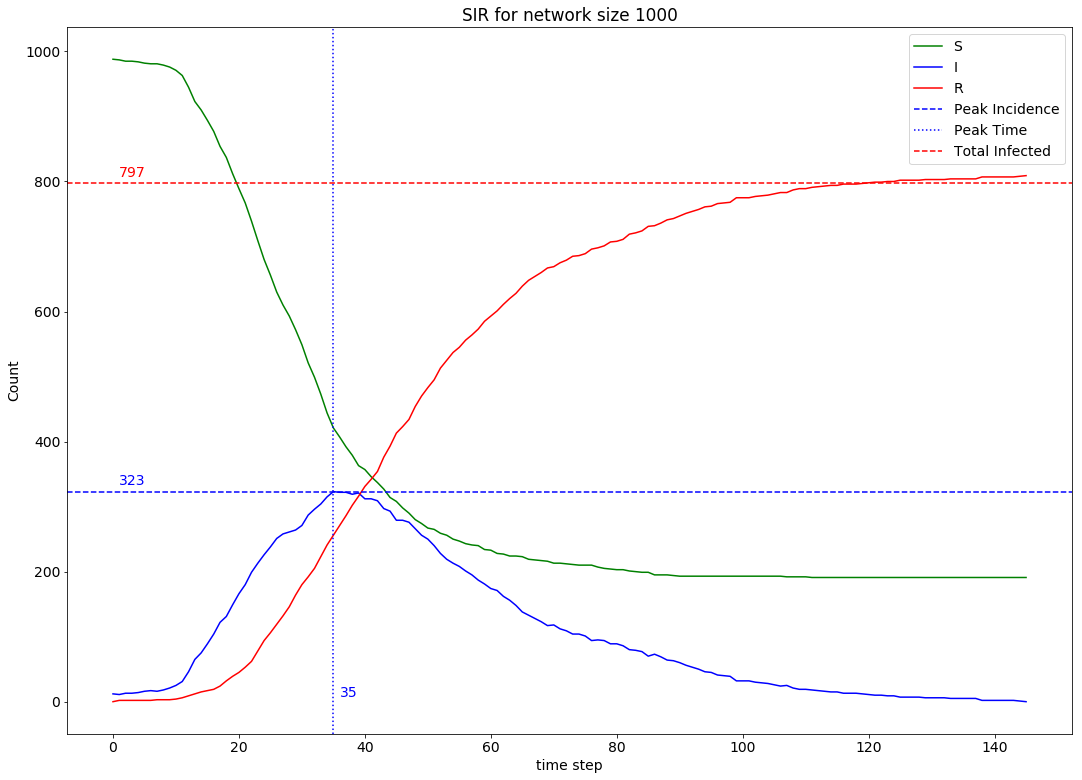

In [4]:
reset(nw) # initialise all nodes to succeptible
S, I, R, endtime, ii = run_spread_simulation(nw, m, number_initial_infections)
plot_infection(S,I,R,nw) 

## Vacination by degree

Now we want to develop a vacination strategy. We specify how many vacinations to apply, then the first strategy we try is to vacinate the nodes with the highest degree. Vacination in this case means we set their state to be removed, i.e., they're already resilient to the the disease.

We first reset the network to be all succeptible, then apply our vacination strategy, then re-run the experiments. You can play around with the number of vacinations to see how many nodes you need to vacinate in order to prevent the outbreak. What happens to the peak-time?

Infected: 0 time step: 3873

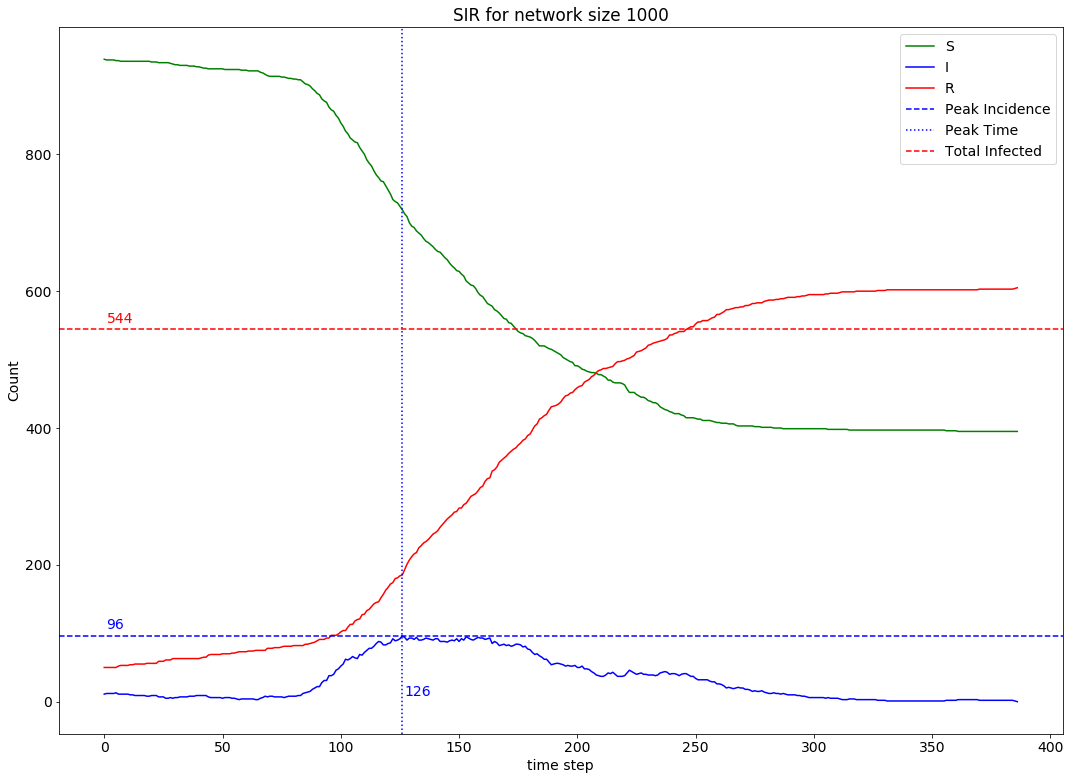

In [8]:
number_to_vacinate = 50

def vacinate_by_degree(G, num_to_vacinate):
    degrees = dict(G.degree()) #get degrees of every node
    #below we sort the nodes in order of their degree, highest degree first.
    nodes_sorted_by_degree = sorted(degrees.items(), key=operator.itemgetter(1), reverse=True) 
    for x in range(num_to_vacinate): #iterate over the sorted nodes, taking the first *num_to_vacinate* nodes to vacinate.
        node_id_to_vacinate = nodes_sorted_by_degree[x]
        G.nodes[node_id_to_vacinate[0]]['state'] = State.Removed #make vacinated nodes removed.

        
reset(nw)        
vacinate_by_degree(nw, number_to_vacinate)
S, I, R, endtime,ii = run_spread_simulation(nw, m, number_initial_infections)
plot_infection(S,I,R,nw)

## Vacinate by betweenness

Now we try a slightly different strategy for vacination and vacinate the nodes with the highest betweenness centrality. Recall betweenness measures the number of shortest paths that a node lies on. More formally the betweenness centrality on node $n_j$ is defined as:

$$ 
g(n_j) \sum_{i \neq j \neq k} = \frac{\sigma_{n_in_k}(n_j)} {\sigma_{n_in_k}}$$

Where $\sigma_{n_in_k}$ is the total number of shortest paths from node $n_i$ to $n_k$ and $\sigma_{n_in_k}(n_j)$ is the number of those paths that pass through node $n_j$


Infected: 0 time step: 2508

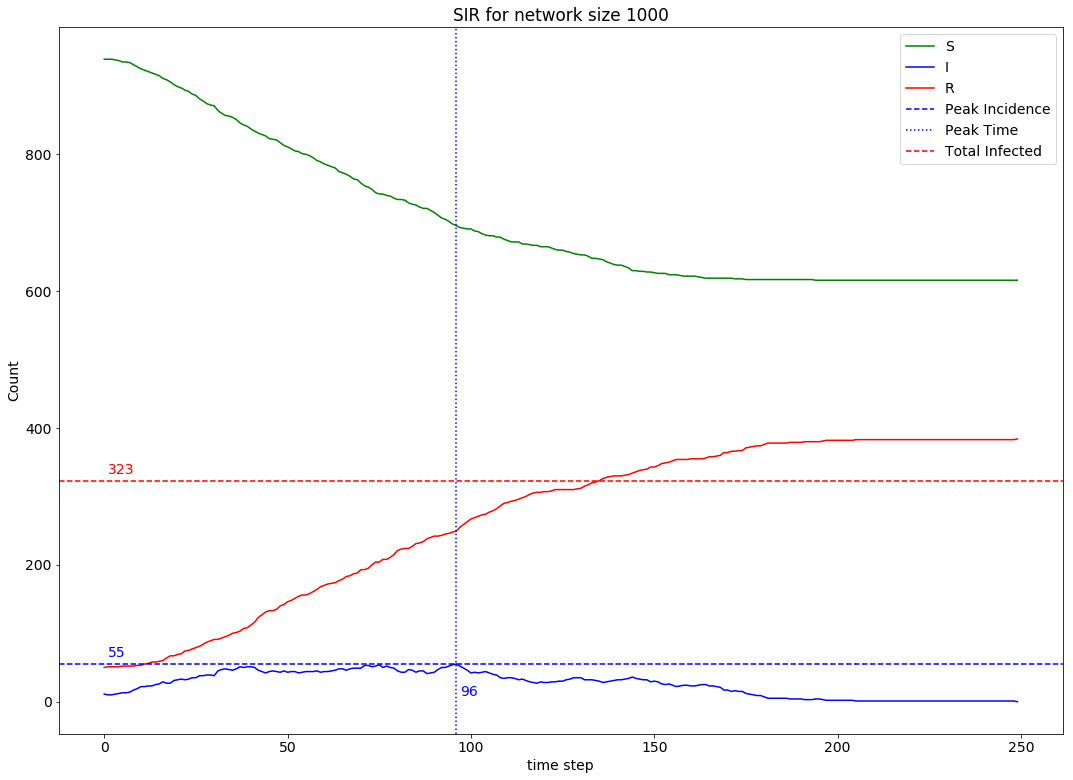

In [9]:
def vacinate_by_betweenness(G, number):
    bet_cen = dict(nx.betweenness_centrality(G))
    nodes_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)
    for x in range(number):
        node_id_to_vacinate = nodes_sorted_by_betweenness[x]
        G.node[node_id_to_vacinate[0]]['state'] = State.Removed #make vacinated nodes removed.        

reset(nw)        
vacinate_by_betweenness(nw, number_to_vacinate)
S, I, R, endtime,ii = run_spread_simulation(nw, m, number_initial_infections)
plot_infection(S,I,R,nw)

## Bonus code

Below are some extra features you can play with at a later date. The first is a graphing package called bokeh that creates nice interactive plots. The second is the Graphiz package which NetworkX can use, however you must have [Graphviz](http://www.graphviz.org/) installed on the system, and also installed in python via pip *"pip install graphviz" *

In [10]:
#Uncomment below if you have graphviz installed
#Graphvix layout and write to file
#pos=nx.graphviz_layout(ba,prog='dot', args="-Goverlap=false" )
#draw_network_to_file(ba,pos,endtime,ii)


from bokeh.plotting import *

output_notebook()

# create a new plot with a title and axis labels
p = figure(title="SIR model", x_axis_label='time step', y_axis_label='count', plot_width=1000, plot_height=800)
xvalues = range(len(S))
# add a line renderer with legend and line thickness
p.line(xvalues, S, legend="Succeptible", line_width=2, line_color="green")
p.line(xvalues, I, legend="Infected", line_width=2, line_color="blue")
p.line(xvalues, R, legend="Recovered", line_width=2, line_color="red")

# show the results
show(p)


Loading BokehJS ...

## Deciding on a Strategy with Incomplete Information

If you run the above experiments repeatedly, you may see in some cases no outbreak occurs, or a very limited outbreak occurs. This is despite the fact that we use the same network in all experiments and we always vaccinate the same individuals in that network. We also always start the initial infection with the same number of individuals

The only initial condition that changes in the current experiments is the set of nodes that we initially infect. This set (althgouh of fixed size) is chosen randomly inside the **initialise_infection** function, this is done with the command **random.sample**. If that initial random sample of people from the graph just so happens to hit one important node (highly connected) the likliehood of an outbreak occuring is high. However, if the sample only contains nodes with very low degree (e.g., 1), then there is good chance that those node will be removed (moved to state R) before they have chance to infect other nodes (obviously this depends on the disease and the values of $\beta$ and $\alpha$)

This level of known and unknown parameters is somewhat realistic. In reality policy makers may have information and data for different aspects of the pandemic. For example, they may have some idea about the network structure, but not all, they may also have an approximation (or range) for $\beta$ and $\alpha$, through data collected at hospitals. However, they will almost never have all the information necessary to make a prediction. In this case it's necessary to assess the sensitivity of the results according to each unknown (and perhaps known) parameter.

## Our Research/Policy Question

You can of course consider many questions to ask of the simulation. We will now ask a relatively simple question.

#### *Assuming a contact network that is scale-free (BA) is it better to vacinate nodes with (a.) higher degree or nodes with (b.) higher betweenness?*

There are a number of things that this answer might depend on, we now will have to run multiple experiments to understand under what conditions strategy A. is better than strategy B. and vice versa. The control parameters in this case are: 1. Method, 2. Number of Vaccinations, 3. Number of initial infections. We also have a stochastic parameter,the set of nodes that are initially infected, which we allow to vary randomly.

We will assume that we know the network (i.e., use a fixed network instance, with a fixed size). We will also assume we know the disease parameters, and that $\alpha = 0.05$, and $\beta = 0.03$. This means at each timestep a node will infect each neighbour with a 3% chance, and has a 5% chance to recover/be removed.

In [11]:
N = 1000 # size of network to make - you can try to make this bigger
ba = nx.barabasi_albert_graph(N, 4) #create BA network
reset(ba) # initialise all nodes to succeptible
m = transmission_model_factory(0.03, 0.05) # create our transmission model with beta and alpha
fraction_initial_infections = [5e-3, 5e-2] #create a range on initial infection counts
fraction_vacinations= [ 5e-3, 1e-2] #create a range of vacination counts
vacination_methods = [vacinate_by_betweenness, vacinate_by_degree]
repetitions = 3 # number of times to run each instance (i.e., vary the starting infection locations)

#Create a list of parameter sets that we want to run.
parameterSets=[]
for method in vacination_methods:
    for inf in fraction_initial_infections:
        for vac_fraction in fraction_vacinations:
            parameterSets.append((method, inf, vac_fraction, repetitions))            

#Function to simulate one parameter set, we run this function in parallel
def simulate(G, vac_method, init_inf, vac_fraction, repetitions, model, return_dict):
    """
    param G: Network to simulate disease on
    param vac_method: Method of vacination, a function describing how to vacinate nodes
    param init_int: Initial fraction of nodes to infect 
    param vac_fraction: Initial fraction of nodes to vacinate
    param repetition: number of repetitions for this parameter set
    param model: A function describing the model used for spread the disease
    param return_dict: A dictionary to store the return values of multilple runs
    
    This function simulates one parameter setting with multiple repititions
    """
    total_peak_incidence = total_peak_time = total_total_infected = 0
    for rep in range(1,repetitions+1):
        reset(G)
        vac_method(G, int(vac_fraction*N))
        S, I, R, endtime, ii = run_spread_simulation(G, model, int(N*inf))
        total_peak_incidence += max(I)
        total_peak_time += I.index(max(I))
        total_total_infected += S[0]-S[-1]
    ave_peak_incidence = total_peak_incidence / repetitions
    ave_peak_time = total_peak_time / repetitions
    ave_total_infected = total_total_infected / repetitions
    
    return_dict[(vac_method,init_inf,vac_fraction)] = (ave_peak_incidence, ave_peak_time, ave_total_infected)

    
#We use the Python multiprocessing to run the code in parallel using multiple cores.

import multiprocessing as mp
manager = mp.Manager() # our process manager
return_dict = manager.dict() #this is the return values from all parallel runs
jobs = [] #list of jobs to send to multiprocessing


#We run each parameter set in parallel
for parameter in parameterSets:
    p = mp.Process(target=simulate, args=(ba,parameter[0],parameter[1],parameter[2],parameter[3],m,return_dict))
    jobs.append(p) #list of jobs so we can wait for them later.
    p.start() #start this process

#This ensures we wait until all jobs are finished before we proceed.
for proc in jobs:
    proc.join()

#this dictionary stores all the results from the runs. 
#The dictionary stores the parameter settings as a key and the average outputs as a value
# print return_dict 

Infected: 0 time step: 1668